## Data

Nous disposons d'un ensemble de données de 17092 images de cellules normales du sang préphérique, les images sont répartis sur 8 classes de types distincts à savoir : 'basophil','eosinophil', 'erythroblast', 'immature granulocytes', 'lymphocyte', 'monocyte', 'neutrophil' et 'platelet'.

Dans ce notebook on va éffectué un audit général de nos images et quelques visualisation.  

## 1. Charger les données

In [ ]:
import pandas as pd
import numpy as np
from termcolor import colored
import random
import glob
import os
import cv2 ## Package pour lire nos images
from PIL import Image ## Importer ce package pour pouvoir voir le format de l'image
import matplotlib.pyplot as plt
%matplotlib inline

import skimage.exposure
import seaborn as sns
from numpy import asarray 
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import MinMaxScaler
from google.colab.patches import cv2_imshow
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"




In [ ]:
!pip install -U -q PyDrive

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Pour connecter colab au Drive
from google.colab import drive
drive.mount('/content/drive')

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile({'q': "'1fOXuSllay_oEjLEj9bmk-7Zx8Uz61KDF' in parents"}).GetList()


# for f in file_list:
#   # 3. Create & download by id.
#   print('title: %s, id: %s' % (f['title'], f['id']))
#   fname = os.path.join(local_download_path, f['title'])
#   print('downloading to {}'.format(fname))
#   f_ = drive.CreateFile({'id': f['id']})
#   f_.GetContentFile(fname)




Mounted at /content/drive


In [ ]:

## Chemin pour aller récupérer les images stockées dans le dossier 'PBC_dataset_normal_DIB'
path = '/content/drive/MyDrive/dataset/PBC_dataset_normal_DIB'

## Créer une liste où stocker les noms des images de nos 8 différentes classes
Classes = []
for element in os.listdir(path):
    img = os.listdir(path+"/" + element)
    Classes.append(img)


# importer toutes les images des 8 différentes classes et les stocker dans un array images : attention c'est une liste et non pas un array
images = []
for element in os.listdir(path) :
    for img in glob.glob(path+element+'/'+'*.jpg'): 
        imge = cv2.imread(img)
        images.append(imge)

# print(type(images))   #list
# print(len(images))    #17092


In [ ]:
## Créer une liste où stocker les noms des images de nos 8 différentes classes
Classes = []
for element in os.listdir(path):
    img = os.listdir(path+'/'+element)
    Classes.append(img)

## 2. Audit

### 2.1. Regarder la répartitions de nos données sur les 8 classes 

In [ ]:
# Afficher la taille de nos classes et le pourcentage de chacune d'entre elle dans un DataFrame
type_cellule=['basophil','eosinophil', 'erythroblast','immature granulocytes','lymphocyte','monocyte','neutrophil',
              'platelet']
Total_Number = []
Percentage = []
for i, Classe in zip(range(len(Classes)),type_cellule):
    Total_Number.append(len(Classes[i]))
    Percentage.append(round(len(Classes[i])/17092 *100,2))

dictionnaire = {'Type_de_Cellule': [i for i in type_cellule],
                'Total' : [j for j in Total_Number],
                '%' : [perc for perc in Percentage]
                 }

data = pd.DataFrame(data = dictionnaire, columns=dictionnaire.keys())
#print(type_cellule)
data

,Type_de_Cellule,Total,%
0,basophil,1218,7.13
1,eosinophil,3117,18.24
2,erythroblast,1551,9.07
3,immature granulocytes,2895,16.94
4,lymphocyte,1214,7.10
5,monocyte,1420,8.31
6,neutrophil,3332,19.49
7,platelet,2348,13.74


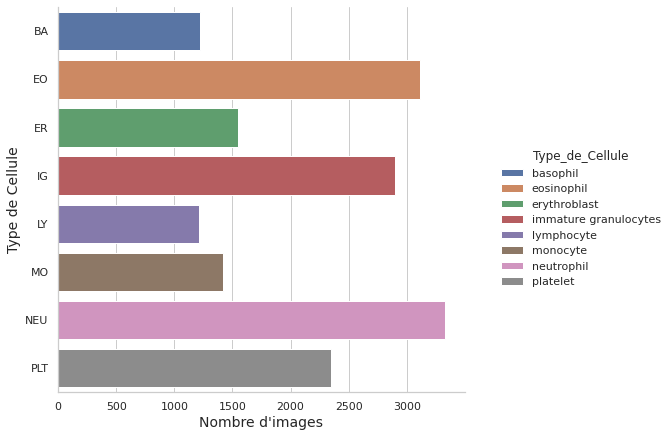

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.catplot(y='Type_de_Cellule',x='Total',hue='Type_de_Cellule' ,data=data,kind='bar',dodge=False,height=8)
g.fig.set_figwidth(12)
g.fig.set_figheight(6)
g.set_yticklabels(["BA", "EO", "ER","IG","LY","MO","NEU","PLT"])
#plt.legend(labels = [name for name in type_cellule],loc='center right',bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.xlabel("Nombre d'images",size=14)
plt.ylabel("Type de Cellule",size=14);

sns.set_theme(style="whitegrid");

##### Taille des images

In [ ]:
# Taille de nos images
for img in images :
  h, w, c = img.shape # on peut utiliser également size qui nous renvois (h*w*c)
     # print("height  :", h)
     # print("width   :", w)
     # print("channel :", c)

# Si jamais dans nos données on a des images avec des tailles différentes des autres, récupérer le nom des images et le 
# stocker dans une liste img_other_size !
img_other_size = []     
for element, Classe in zip(os.listdir(path),Classes) :
  for img, imge in zip(glob.glob(path+element+'/'+'*.jpg'), Classe) : 
    if cv2.imread(img).shape != (363,360,3) :
      img_other_size.append(imge)


In [ ]:
print(colored(len(img_other_size),attrs=['bold']),"images possèdent une taille différente de la taille des autres images !")

0 images possèdent une taille différente de la taille des autres images !


##### Format des images

In [ ]:
## format de nos images
for element in os.listdir(path) :
  for img in glob.glob(path+element+'/'+'*.jpg'):
    print(Image.open(img).format) 

# Si il y'a des images avec un format différent des autres images, on va les récupérer et ensuite les stocker dans la liste
# img_other_format        
img_other_format = []

for element, Classe in zip(os.listdir(path),Classes) :
  for img, imge in zip(glob.glob(path+element+'/'+'*.jpg'), Classe) : 
    if Image.open(img).format != 'JPEG' :
      img_other_format.append(imge)

if not(img_other_format) :
  print(colored("toutes nos images ont le même format !",attrs=['bold']))
else : 
  print(colored(len(img_other_format),attrs=['bold']), colored("de nos images ont un autre format que le fotmat 'JPEG' !",attrs=['bold']))

toutes nos images ont le même format !


Resizer les images qui ne sont pas a la bonne taille c-à-d, 363*360

In [ ]:

# def count_em(path):
#     for root, dirs, files in sorted(os.walk(path)):
#         for file_ in files:
#             full_file_path = os.path.join(root, file_)
#             # print (full_file_path)
#             # print (file_)
#             img = Image.open(full_file_path)
#             new_width  = 360
#             new_height = 360
#             img = img.resize((new_width, new_height), Image.ANTIALIAS)
#             # os.makedirs("Dataset_resized/") 
#             # cv2.imwrite('myImage.png', img)
#             # img.save(os.path.join(root, file_))
#             # print(img)
#     return 

# count_em(path)

#j'ai un doute sur l'enregistrement de l'image.Lieu? Si ecrase l'autre? 
#Est_ce que les images sont deformées? Comment etre sur?


Il faut changer la taille des 453 images qui n'ont pas la meme taille que les autres.

In [ ]:
# # Import des différents dossiers de cellules

basophil_list = [cv2.imread(file) for file in glob.glob(path + "/basophil/*.jpg")]
eosinophil_list = [cv2.imread(file) for file in glob.glob(path + "/eosinophil/*.jpg")]
# erythroblast_list = [cv2.imread(file) for file in glob.glob(path + "/erythroblast/*.jpg")]
# ig_list = [cv2.imread(file) for file in glob.glob(path + "/ig/*.jpg")]
# lymphocyte_list = [cv2.imread(file) for file in glob.glob(path +"/lymphocyte/*.jpg")]
# monocyte_list = [cv2.imread(file) for file in glob.glob(path + "/monocyte/*.jpg")]
# neutrophil_list = [cv2.imread(file) for file in glob.glob(path +"/neutrophil/*.jpg")]
# platelet_list = [cv2.imread(file) for file in glob.glob(path + "/platelet/*.jpg")]


In [ ]:
# Stockage des dimensions de chaque image + le type de cellule correspondant  
x, y, z, type_cell = [],[],[],[]

data_infos = pd.DataFrame()
for i in basophil_list:
    x_dim, y_dim, z_dim = i.shape
    x.append(x_dim)
    y.append(y_dim)
    z.append(z_dim)
    type_cell.append('basophil')

for i in eosinophil_list:
    x_dim, y_dim, z_dim = i.shape
    x.append(x_dim)
    y.append(y_dim)
    z.append(z_dim)
    type_cell.append('eosinophil')

# for i in erythroblast_list:
#     x_dim, y_dim, z_dim = i.shape
#     x.append(x_dim)
#     y.append(y_dim)
#     z.append(z_dim)
#     type_cell.append('erythroblast')
    
# for i in ig_list:
#     x_dim, y_dim, z_dim = i.shape
#     x.append(x_dim)
#     y.append(y_dim)
#     z.append(z_dim)
#     type_cell.append('ig')
    
# for i in lymphocyte_list:
#     x_dim, y_dim, z_dim = i.shape
#     x.append(x_dim)
#     y.append(y_dim)
#     z.append(z_dim)
#     type_cell.append('lymphocyte')
    
# for i in monocyte_list:
#     x_dim, y_dim, z_dim = i.shape
#     x.append(x_dim)
#     y.append(y_dim)
#     z.append(z_dim)
#     type_cell.append('monocyte')
    
# for i in neutrophil_list:
#     x_dim, y_dim, z_dim = i.shape
#     x.append(x_dim)
#     y.append(y_dim)
#     z.append(z_dim)
#     type_cell.append('neutrophil')

# for i in platelet_list:
#     x_dim, y_dim, z_dim = i.shape
#     x.append(x_dim)
#     y.append(y_dim)
#     z.append(z_dim)
#     type_cell.append('platelet')
    
data_infos=pd.DataFrame({'x':x
                ,'y':y
                ,'z':z
                ,'type_cell':type_cell})

data_infos.head(5)

,x,y,z,type_cell
0,363,360,3,basophil
1,363,360,3,basophil
2,363,360,3,basophil
3,363,360,3,basophil
4,363,360,3,basophil


In [ ]:
#Nombres d'images par types de cellules
data_infos['type_cell'].value_counts()

eosinophil    3117
basophil      1218
Name: type_cell, dtype: int64

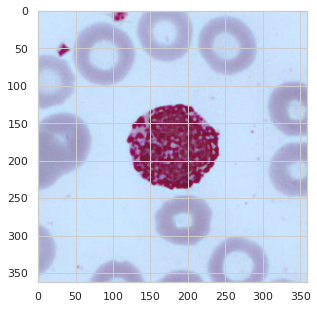

In [ ]:
#affichage image
plt.figure(figsize = (5,5))
plt.imshow(basophil_list[22])
plt.show();

### 2.2. Visalisation des différents classes de cellules

Text(0.5, 1.0, 'basophil')

Text(0.5, 1.0, 'eosinophil')

Text(0.5, 1.0, 'erythroblast')

Text(0.5, 1.0, 'immature granulocytes')

Text(0.5, 1.0, 'lymphocyte')

Text(0.5, 1.0, 'monocyte')

Text(0.5, 1.0, 'neutrophil')

Text(0.5, 1.0, 'platelet')

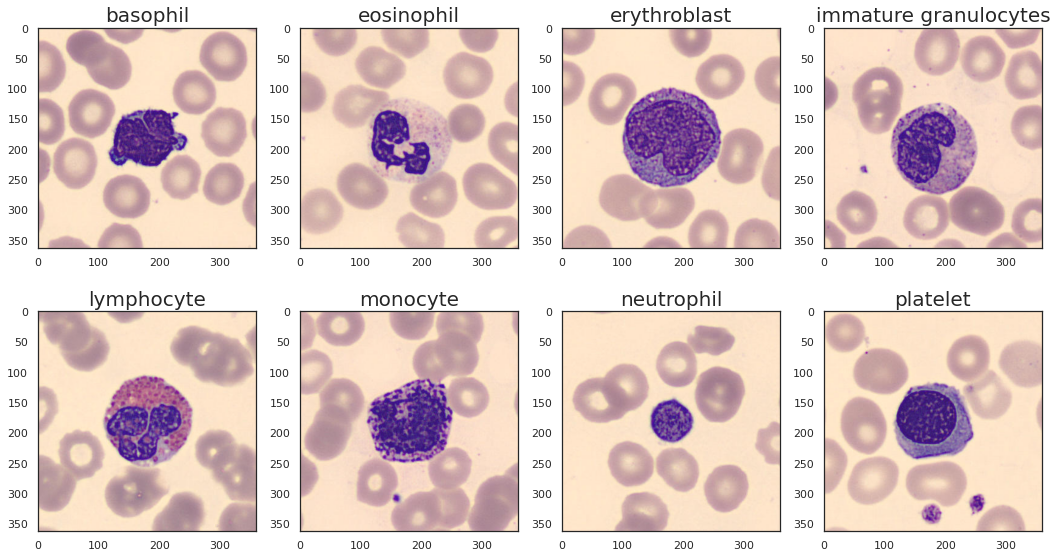

In [ ]:
#------- Afficher pour chaque type de cellules une image, qu'on récupére du manière aléatoire ---------#
# selectionner une cellule de chaque type de classe et les visualiser avec plt.imshow
img_random = []
for i in range(len(Classes)) :
  for j in range(1):
    img = random.choice(Classes[i])
    img_random.append(img)

noms_classe = ['basophil','eosinophil','erythroblast','immature granulocytes','lymphocyte','monocyte','neutrophil',
               'platelet']

sns.set_theme(style="white")
fig= plt.figure(figsize=(18,20))   
for i in range(8):        
    # subplots
    plt.subplot(4, 4, i+1)   
    # Afficher l'image
    plt.imshow(cv2.cvtColor(cv2.imread(path+'/'+ os.listdir(path)[i]+'/'+img_random[i],cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB));  
    # set the title to subplots
    plt.gca().set_title(noms_classe[i],size=20) ;

### PREPROCESSING

#### Distribution des couleurs et noirs/blancs d'une image

<Figure size 1440x1440 with 0 Axes>

TypeError: ignored

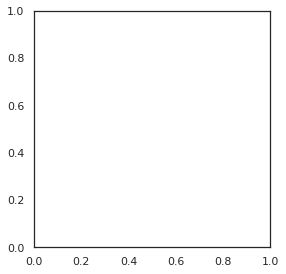

In [ ]:
#Importation de l'image
#Lecture des images en mode noir et blanc ou couleurs
#transformation de l'image couleur en noir et blanc


img = cv2.imread("/content/drive/MyDrive/dataset/PBC_dataset_normal_DIB/lymphocyte/LY_133266.jpg")
img_gray = cv2.imread(str(img), cv2.IMREAD_GRAYSCALE)
img_color = cv2.imread(str(img), cv2.IMREAD_COLOR)
img_gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Definir les dimensions des images
# print(img_color.shape)
# print(img_gray.shape)

# plt.imshow(plt.imread(path))
#histogramme en noir et blanc
white_hist = cv2.calcHist([img_gray2],[0],None,[256],[0,256])

# white_hist = cv2.calcHist([basophil_list[22], cv2.COLOR_BGR2GRAY], [0], None, [256], [0, 256])
# plt.plot(white_hist, color='k')
# plt.show()

#Affichage des images et histogrammes
plt.figure(figsize = (20,20))
plt.subplot(421), plt.imshow(img_color, 'gray'), plt.title('Color')
plt.subplot(422), plt.imshow(img_gray, 'gray'), plt.title('White')
plt.subplot(424), plt.plot(white_hist), plt.title('White')
plt.xlim([0,256])

#histogramme en couleurs
color = ('b','g','r')
for i,col in enumerate(color):
    color_hist = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.subplot(423), plt.plot(color_hist,color = col)
    plt.xlim([0,256])
    plt.title('RGB')
    


In [ ]:
Il faut faire attention que les images soient bien en 2D. 

Transformation de l'image de RGB -> HSV

In [ ]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# plt.figure(figsize = (20,20))

print(hsv.shape)
#Déclaration des couleurs des courbes
color = ('r','g','b')
#Déclaration des noms des courbes.
labels = ('h','s','v')
#Pour col allant r à b et pour i allant de 0 au nombre de couleurs
plt.figure(figsize = (10,10))
for i,col in enumerate(color):
    #Hist prend la valeur de l'histogramme de hsv sur la canal i.
    hist_hsv = cv2.calcHist([hsv],[i],None,[256],[0,256])

    # Plot de hist.
    plt.subplot(223),plt.plot(hist_hsv,color = col,label=labels[i])
    plt.title('HSV')
    plt.legend()
    plt.xlim([0,256])

plt.subplot(221), plt.imshow(img_color, 'gray'), plt.title('Color')
plt.subplot(222), plt.imshow(hsv, 'gray'), plt.title('hsv') 
    
#Affichage.
# plt.show()

Transformation de l'image de RGB -> LAB.

In [ ]:
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
# lab_hist = cv2.calcHist([lab],[i],None,[256],[0,256])

#Déclaration des couleurs des courbes
color = ('r','g','b')
#Déclaration des noms des courbes.
labels = ('l','a','b')
#Pour col allant r à b et pour i allant de 0 au nombre de couleurs
plt.figure(figsize = (10,10))
for i,col in enumerate(color):
    #Hist prend la valeur de l'histogramme de hsv sur la canal i.
    lab_hist = cv2.calcHist([lab],[i],None,[256],[0,256])
        # Plot de hist.
    plt.subplot(223),plt.plot(hist_hsv,color = col,label=labels[i])
    plt.title('LAB')
    plt.legend()
    plt.xlim([0,256])


plt.subplot(221), plt.imshow(img_color, 'gray'), plt.title('Color')
plt.subplot(222), plt.imshow(lab, 'gray'), plt.title('Lab') 

plt.xlim([0,256])


## SEGMENTATION PAR SEUILLAGE (OTSU)
Le seuillage d'otsu binarise l'image

### Seuillage d'otsu sur les images HSV

In [ ]:
h,s,v= cv2.split(hsv)
ret_h, th_h = cv2.threshold(h,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret_s, th_s = cv2.threshold(s,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret_v, th_v = cv2.threshold(v,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
cv2.imwrite("th_h.png",th_h)
cv2.imwrite("th_s.png",th_s)
cv2.imwrite("th_v.png",th_v)

#histogramme en noir et blanc
hsv_hist = cv2.calcHist([th_s],[0],None,[256],[0,256])

plt.figure(figsize = (10,10))
plt.subplot(141), plt.imshow(th_h, 'gray'), plt.title('Teinte Seuillée')
plt.subplot(143), plt.imshow(th_s, 'gray'), plt.title('Saturation Seuillée')
plt.subplot(142), plt.imshow(th_v, 'gray'), plt.title('Luminosité Seuillée')
# plt.subplot(144), plt.plot(hsv_hist, 'gray'), plt.title('Luminosité Seuillée')

# On constate que la saturation nous permet de segmenter les cellules

# plt.imshow('th_h.png', th_h)

In [ ]:
Seuillage d'otsu sur les images Lab

In [ ]:
l,a,b= cv2.split(lab)
ret_l, th_l = cv2.threshold(l,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret_a, th_a = cv2.threshold(a,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret_b, th_b = cv2.threshold(b,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
cv2.imwrite("th_l.png",th_l)
cv2.imwrite("th_a.png",th_a)
cv2.imwrite("th_b.png",th_b)

plt.figure(figsize = (10,10))
plt.subplot(131), plt.imshow(th_l, 'gray'), plt.title('L Seuillée')
plt.subplot(132), plt.imshow(th_a, 'gray'), plt.title('A Seuillée')
plt.subplot(133), plt.imshow(th_b, 'gray'), plt.title('B Seuillée')
# On constate que L et B segmentent bien les cellules
# plt.imshow('th_h.png', th_h)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Reduction du bruit des images
On peut flouter ou smoother
Smoothing = Gaussian Blur, Median Blur avec cv2.blur() , cv2.GaussianBlur() and cv2.medianBlur()

In [ ]:
img= cv2.GaussianBlur(img_gray, (3, 3), 0)
th_l_blurred = cv2.GaussianBlur(th_l, (3,3),0)
th_s_blurred = cv2.GaussianBlur(th_s, (3,3),0)

plt.figure(figsize = (10,10))
plt.subplot(131), plt.imshow(img, 'gray'), plt.title('Original Seuillée & Floutée')
plt.subplot(132), plt.imshow(th_l_blurred, 'gray'), plt.title('L Seuillée & Floutée')
plt.subplot(133), plt.imshow(th_s_blurred, 'gray'), plt.title('S Seuillée & Floutée')

SEGMENTATION PAR CLUSTERING
UTiliser HSV et LAB 

KMEAN
Appliquée sur les images LAB et HSV

1. Image Segmentation using K-means

Reshape it along the first axis to convert it into a 2D vector 
i.e. if the image is of the shape (100,100,3) (width, height, channels) then it will be converted to (10000,3).
Next, convert it into the float datatype.

In [ ]:
#verification de la taille de l'image car il faut une image 2D
print(th_l_blurred.shape)
print(img.shape)

# #conversion de la taille de l'image en vecteur 2D
# twoDimage = img.reshape((-1,3))
# twoD_th_s_blurred = th_s_blurred.reshape((-1,3))
# twoD_th_l_blurred = th_l_blurred.reshape((-1,3))

#Conversion des images de nparray en float
print(type(th_l_blurred))
img = np.float32(img)
th_s_blurred = np.float32(th_s_blurred)
th_l_blurred = np.float32(th_l_blurred)


DEFINING PARAMETERS

Define the criteria by which the K-means algorithm is supposed to cluster pixels.

The ‘K’ variable defines the no of clusters/groups that a pixel can belong to (You can increase this value to increase the degree of segmentation).

In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0)
K = 2
attempts=10

iv) Apply K-Means

The K variable randomly initiates K different clusters and the ‘center’ variable defines the center of these clusters. The distance of each point from these centers is computed and then they are assigned to one of the clusters. Then they are divided into different segments according to the value of their ‘label variable’.

In [ ]:
ret,label,center=cv2.kmeans(img,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))

plt.figure(figsize = (10,10))
plt.subplot(131), plt.imshow(result_image, 'gray'), plt.title('Original')

# Graphique des centroïdes
plt.scatter(center[:, 0],center[:, 1], marker = "o", color = "red",s=30, linewidths = 1, zorder = 10)
plt.show()

# print(label)

# #plotting the labels results: les resultats ne semblent pas bons 
# for i in label:
#     if i == 1: 
#         plt.scatter(img[:,0], img[:,1], label = i)
# # plt.legend()

# plt.xlim([0, 360])
# plt.ylim([0, 360])
# plt.show()


In [ ]:
ret,label,center=cv2.kmeans(th_l_blurred,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image_lab = res.reshape((th_l_blurred.shape))

# print(label)
plt.figure(figsize = (10,10))
plt.subplot(131), plt.imshow(result_image_lab), plt.title('LAB')

# Graphique des centroïdes
plt.scatter(center[:, 0],center[:, 1], marker = "o", color = "red",s=30, linewidths = 1, zorder = 10)
plt.show()

# #plotting the labels results: es resultats ne semblent pas bons 
# for i in label:
#     if i == 1: 
#         plt.scatter(th_l_blurred[:, 0], th_l_blurred[:, 1], label = i)
# plt.xlim([0, 360])
# plt.ylim([0, 360])
# plt.show()


In [ ]:
ret,label,center=cv2.kmeans(th_s_blurred,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image_hsv = res.reshape((th_s_blurred.shape))

plt.figure(figsize = (10,10))
plt.subplot(131), plt.imshow(result_image_hsv), plt.title('Original')

# Graphique des centroïdes
plt.scatter(center[:, 0],center[:, 1], marker = "o", color = "red",s=30, linewidths = 1, zorder = 10)
plt.show()

# #plotting the results: les resultats ne semblent pas bons 
# for i in label:
#     if i == 1: 
#         plt.scatter(img[0], img[1], label = i)
# # plt.legend()

# plt.xlim([0, 360])
# plt.ylim([0, 360])
# plt.show()

In [ ]:
MEANSHIFT

Creation d'un vecteur pour chaque pixel avec les couleurs et leur position

Pour l'image d'origine

In [ ]:
index = pd.MultiIndex.from_product((*map(range, img.shape[:2]),('r', 'g', 'b')),names=('row', 'col', None))
# print(index)
df_1 = pd.Series(img.flatten(), index=index)
df_1 = df_1.unstack()
df_1 = df_1.reset_index().reindex(columns=['col','row','r','g','b'])
df_1.head(10)

Pour l'image LAB

In [ ]:
index = pd.MultiIndex.from_product((*map(range, th_l_blurred.shape[:2]),('l', 'a', 'b')),names=('row', 'col', None))
df_2 = pd.Series(th_l_blurred.flatten(), index=index)
df_2 = df_2.unstack()
df_2 = df_2.reset_index().reindex(columns=['col','row','l','a','b'])
df_2.head(10)

Pour l'image HSV

In [ ]:
index = pd.MultiIndex.from_product((*map(range, th_s_blurred.shape[:2]),('h', 's', 'v')),names=('row', 'col', None))
df_3 = pd.Series(th_s_blurred.flatten(), index=index)
df_3 = df_2.unstack()
df_3= df_2.reset_index().reindex(columns=['col','row','h','s','v'])
df_3.head(10)

Creation d'un dataframe qui ne contient que les pixels contenant des valeurs dans les couleurs des images recherchées

In [ ]:
df_rgb = df_1['r', 'g', 'b']
df_lab = df_2['l', 'a', 'b']
df_hsv = df_3['h', 's', 'v']

Normalisation des Pixels to 0–1

Normalisation des pixels pour les images RGB

In [ ]:
ndf_1 = MinMaxScaler(feature_range=(0, 1)).fit_transform(df_1)
ndf_2 = MinMaxScaler(feature_range=(0, 1)).fit_transform(df_rgb)


Calcul du meilleur Bandwith


In [ ]:
bandwidth_1 = estimate_bandwidth(nd_1, quantile=.04, n_jobs=-1)
bandwidth_2 = estimate_bandwidth(nd_2, quantile=.04, n_jobs=-1);

In [ ]:
#@title Default title text
Lancement Clustering

In [ ]:
ms_1 = MeanShift(bandwidth = bandwidth_1 , n_jobs=-1, bin_seeding=True, cluster_all=True).fit(nd_1)
ms_2 = MeanShift(bandwidth = bandwidth_2 , n_jobs=-1, bin_seeding=True, cluster_all=True).fit(nd_2)

plt.figure(1)
plt.clf()
plt.axis('off')
plt.title('Original image', loc='center')
plt.imshow(image)

plt.figure(2)
plt.clf()
plt.axis('off')
plt.title('Pixels with their location image ({} colors, Mean-Shift)'.format(len(ms_1.cluster_centers_)), loc='center')
plt.imshow(recreate_image(ms_1.cluster_centers_[:, 2:], ms_1.labels_, width, height));

plt.figure(3)
plt.clf()
plt.axis('off')
plt.title('Pixels without their location ({} colors, Mean-Shift)'.format(len(ms_2.cluster_centers_)), loc= 'center')
plt.imshow(recreate_image(ms_2.cluster_centers_, ms_2.labels_, width, height));

In [ ]:
DETECTION DES CONTOURS AVEC FILTRE DE CANNY SUITE AU CLUSTERING

In [ ]:
edges_rgb = cv2.dilate(cv2.Canny(img,0,255),None)
edges_lab = cv2.dilate(cv2.Canny(th_l_blurred,0,255),None)
edges_hsv = cv2.dilate(cv2.Canny(th_s_blurred,0,255),None)

In [ ]:
ENTRAINEMENT D'UN MODEL

In [ ]:
Commencer à faire un model avec le SVM et peut random forest avec gradient Boosting
Faire un comparatif avec ou sans preprocessing dans les models

ETUDE DU GRADIENT(Magnitude et Orientation) avec Filtre de Sobel

Affichage des gradients sur les images RGB non seuillées 

In [ ]:
img= cv2.GaussianBlur(img_gray, (3, 3), 0)

sobelx = cv2.Sobel(img_gray,cv2.CV_64F,1,0,ksize=5)

sobely = cv2.Sobel(img_gray,cv2.CV_64F,0,1,ksize=5)

abs_grad_x = cv2.convertScaleAbs(sobelx)

abs_grad_y = cv2.convertScaleAbs(sobely)

modgrad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

  
plt.figure(figsize = (10,10))
plt.subplot(1,4,1),plt.imshow(img,cmap = 'gray')

plt.title('Original'), plt.xticks([]), plt.yticks([])

plt.subplot(1,4,2),plt.imshow(modgrad,cmap = 'gray')

plt.title('Module gradient'), plt.xticks([]), plt.yticks([])

plt.subplot(1,4,3),plt.imshow(sobelx,cmap = 'gray')

plt.title('Sobel X'), plt.xticks([]), plt.yticks([])

plt.subplot(1,4,4),plt.imshow(sobely,cmap = 'gray')

plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

Affichage des gradients sur les images HSV seuillées 

In [ ]:
img= cv2.GaussianBlur(img_gray, (3, 3), 0)

sobelx = cv2.Sobel(th_l,cv2.CV_64F,1,0,ksize=5)

sobely = cv2.Sobel(th_l,cv2.CV_64F,0,1,ksize=5)

abs_grad_x = cv2.convertScaleAbs(sobelx)

abs_grad_y = cv2.convertScaleAbs(sobely)

modgrad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

  
plt.figure(figsize = (10,10))
plt.subplot(1,4,1),plt.imshow(img,cmap = 'gray')

plt.title('Original'), plt.xticks([]), plt.yticks([])

plt.subplot(1,4,2),plt.imshow(modgrad,cmap = 'gray')

plt.title('Module gradient'), plt.xticks([]), plt.yticks([])

plt.subplot(1,4,3),plt.imshow(sobelx,cmap = 'gray')

plt.title('Sobel X'), plt.xticks([]), plt.yticks([])

plt.subplot(1,4,4),plt.imshow(sobely,cmap = 'gray')

plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

#on constate que le gradient est moins bon sur les couleurs LAB